In [4]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 82.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 89.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 86.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 97.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.1
    Uninstalling numpy-2.2.1:
      Successfully uninstalled numpy-2.2.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install python_dotenv

In [7]:
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow import nn
import statsmodels.api as sm

In [8]:
# Standardisation de la taille de chaque image
mpl.rcParams['figure.figsize'] = (15,9)
mpl.rcParams['font.size'] = 15

In [11]:
import fonctions as f

In [4]:
# Chemin du fichier CSV
chemin_fichier = './base.csv'  # Remplacez par le chemin réel

# Charger le fichier CSV dans un DataFrame
df = f.pd.read_csv(chemin_fichier)
df.head()

,DATE,RR,TN,HTN,TX,HTX,TM,TMNX,DG,TAMPLI,...,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ETPGRILLE,NEIGETOTX,NEIGETOT06
0,2022-01-05,2.6,-0.4,1759.0,3.4,1217.0,0.9,1.50,389.0,3.8,...,1244.0,99.0,329.0,0.0,1157.0,5.7,88.0,0.4,0.0,0.0
1,2022-01-06,0.0,-2.5,1746.0,4.3,1327.0,-0.6,0.90,964.0,6.8,...,1032.0,99.0,2304.0,0.0,1043.0,5.1,88.0,0.6,0.0,0.0
2,2022-01-07,10.0,-6.9,718.0,1.6,2229.0,-1.2,-2.65,674.0,8.5,...,708.0,99.0,126.0,0.0,1440.0,5.4,96.0,0.0,0.0,0.0
3,2022-01-08,13.2,-0.7,733.0,6.3,2319.0,2.4,2.80,87.0,7.0,...,1403.0,99.0,618.0,0.0,1231.0,6.4,89.0,0.5,0.0,0.0
4,2022-01-09,7.6,0.4,737.0,2.2,601.0,1.8,1.30,0.0,1.8,...,3.0,98.0,745.0,0.0,1440.0,6.5,94.0,0.1,0.0,0.0


# I) Modélisation en utilisant les séries temporelles

## Application de la standardisation pour attenuer l'effet de la saisonnalité des variables

In [5]:
# Initialiser le scaler
scaler = f.StandardScaler()

# Centrer et réduire toutes les colonnes (puisque toutes sont numériques)
df_standardise = f.pd.DataFrame(
    scaler.fit_transform(df.drop(columns='DATE')), 
    index=df.DATE,  # Conserver l'index d'origine (DATE)
    columns=df.drop(columns='DATE').columns  # Conserver les noms des colonnes
)

# Afficher les premières lignes des données transformées
print(df_standardise.head())


                  RR        TN       HTN        TX       HTX        TM  \
DATE                                                                     
2022-01-05 -0.145556 -0.875833  1.400018 -1.730651 -0.406054 -1.480934   
2022-01-06 -0.510261 -1.193486  1.381189 -1.626404  0.071772 -1.689355   
2022-01-07  0.892453 -1.859045 -0.107733 -1.939145  3.989946 -1.772723   
2022-01-08  1.341321 -0.921212 -0.086008 -1.394744  4.380895 -1.272512   
2022-01-09  0.555801 -0.754822 -0.080214 -1.869647 -3.081881 -1.355881   

                TMNX        DG    TAMPLI     TNTXM  ...       HUN        UX  \
DATE                                                ...                       
2022-01-05 -1.464224  0.834364 -1.524584 -1.466111  ... -0.020220  0.423007   
2022-01-06 -1.549044  2.707071 -1.024689 -1.550864  ... -0.573653  0.423007   
2022-01-07 -2.050895  1.762575 -0.741414 -2.059388  ... -1.419465  0.423007   
2022-01-08 -1.280447 -0.149214 -0.991362 -1.282477  ...  0.394854  0.423007   
2022-01


## Séparartion du train et du test


In [6]:
import pandas as pd

# Supposons que df_standardise est déjà trié par ordre chronologique (ancien au récent).
# Si nécessaire, triez-le :
df_standardise = df_standardise.sort_index()  # Si votre index est de type datetime

# Définir la proportion des données pour l'ensemble d'entraînement
train_size = 0.8  # Par exemple, 80% pour l'entraînement

# Calculer l'indice de séparation
train_index = int(len(df_standardise) * train_size)

# Diviser les données
train = df_standardise.iloc[:train_index]  # Les données les plus anciennes
test = df_standardise.iloc[train_index:]   # Les données les plus récentes

# Vérification
print(f"Taille de l'ensemble d'entraînement : {len(train)}")
print(f"Taille de l'ensemble de test : {len(test)}")

# Afficher un aperçu des données
print("Train :")
print(train.tail())
print("\nTest :")
print(test.head())

test.head()

Taille de l'ensemble d'entraînement : 817
Taille de l'ensemble de test : 205
Train :
                  RR        TN       HTN        TX       HTX        TM  \
DATE                                                                     
2024-04-05 -0.510261  0.576296 -0.394510  0.539619  0.097835  0.783912   
2024-04-06 -0.510261  1.196476 -0.413339  0.829194  0.002270  1.228544   
2024-04-07 -0.510261  0.561169 -0.490102  0.910275 -0.023794  1.145175   
2024-04-08  1.229104  0.288895 -0.488654  0.840777  0.206432  0.881175   
2024-04-09 -0.033338 -0.043884  0.025516 -0.838759  1.079551 -0.605564   

                TMNX        DG    TAMPLI     TNTXM  ...       HUN        UX  \
DATE                                                ...                       
2024-04-05  0.599729 -0.432563  0.141735  0.596235  ... -0.302157 -4.526414   
2024-04-06  1.066239 -0.432563 -0.124876  1.062382  ... -0.785106 -8.333661   
2024-04-07  0.818848 -0.432563  0.691620  0.822246  ... -0.304768 -3.955327   
2

,RR,TN,HTN,TX,HTX,TM,TMNX,DG,TAMPLI,TNTXM,...,HUN,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ETPGRILLE,NEIGETOTX,NEIGETOT06
DATE,,,,,,,,,,,,,,,,,,,,,
2024-04-10,-0.510261,-0.573306,-0.391613,-0.665014,0.080459,-0.702827,-0.672570,-0.432563,-0.324834,-0.675074,...,0.209507,0.042282,-0.248943,-0.488202,-0.534783,-0.931410,-0.178069,-0.153477,-0.136106,-0.124371
2024-04-11,-0.510261,-0.996844,-0.419132,-0.085864,1.023080,-0.508301,-0.517067,0.352345,0.974895,-0.519691,...,-0.354368,0.042282,-0.231612,-0.488202,-0.354878,-0.781062,-0.261017,0.017698,-0.136106,-0.124371
2024-04-12,-0.482207,-0.754822,-0.520518,0.504870,0.063084,0.005805,-0.043489,-0.432563,1.558107,-0.039419,...,0.159907,0.232644,-0.226280,-0.488202,-0.267737,-0.204730,-0.178069,0.131815,-0.136106,-0.124371
2024-04-13,-0.510261,-0.346411,-0.643629,0.979773,0.488784,0.394859,0.437158,-0.432563,1.791391,0.440853,...,0.392244,0.232644,-0.232946,-0.227065,-0.191839,0.196197,-0.261017,0.474165,-0.136106,-0.124371
2024-04-14,-0.510261,-0.285906,-0.684184,1.072437,0.141274,0.644964,0.521978,-0.432563,1.858044,0.525607,...,0.995276,0.232644,-0.222280,1.174550,-0.354878,0.346545,-0.592807,0.588282,-0.136106,-0.124371


## 1)Test de stationnarité

### a) Représentation de la variable cible

In [7]:
df['DATE'] = f.pd.to_datetime(df['DATE'])

In [8]:
df_standardise.index = f.pd.to_datetime(df_standardise.index)

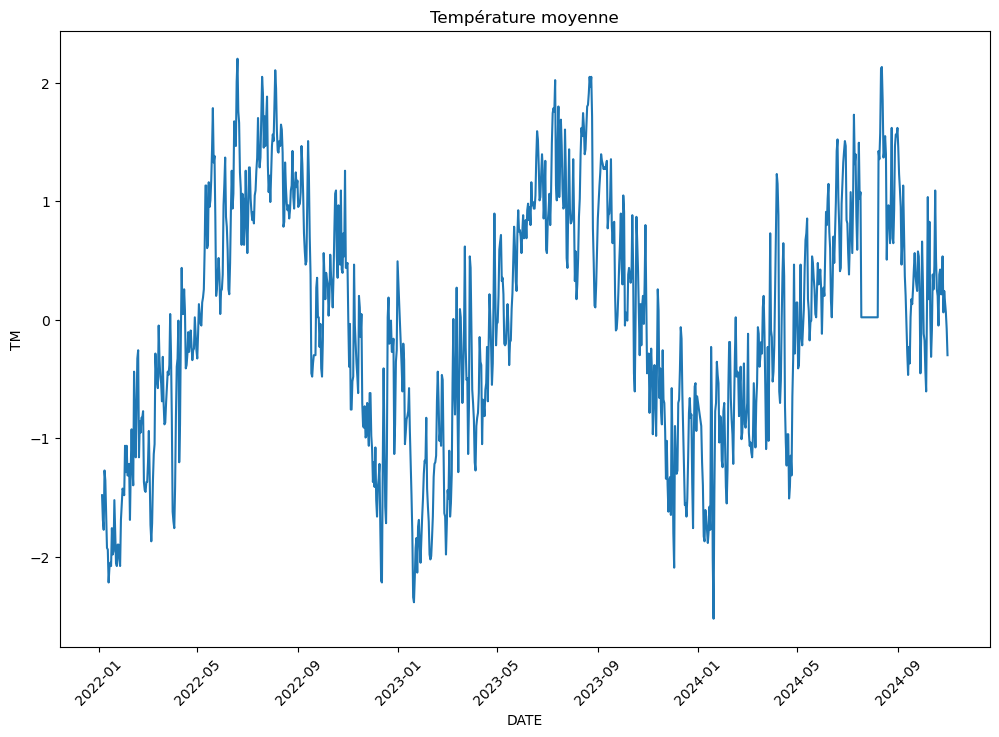

In [9]:
# Configurer la taille des images globalement
f.plt.rcParams['figure.figsize'] = [12, 8]  # Largeur, hauteur en pouces

f.sns.lineplot(x=df_standardise.index, y=df_standardise['TM'])
f.plt.xticks(rotation=45)
f.plt.title("Température moyenne")
f.plt.show()

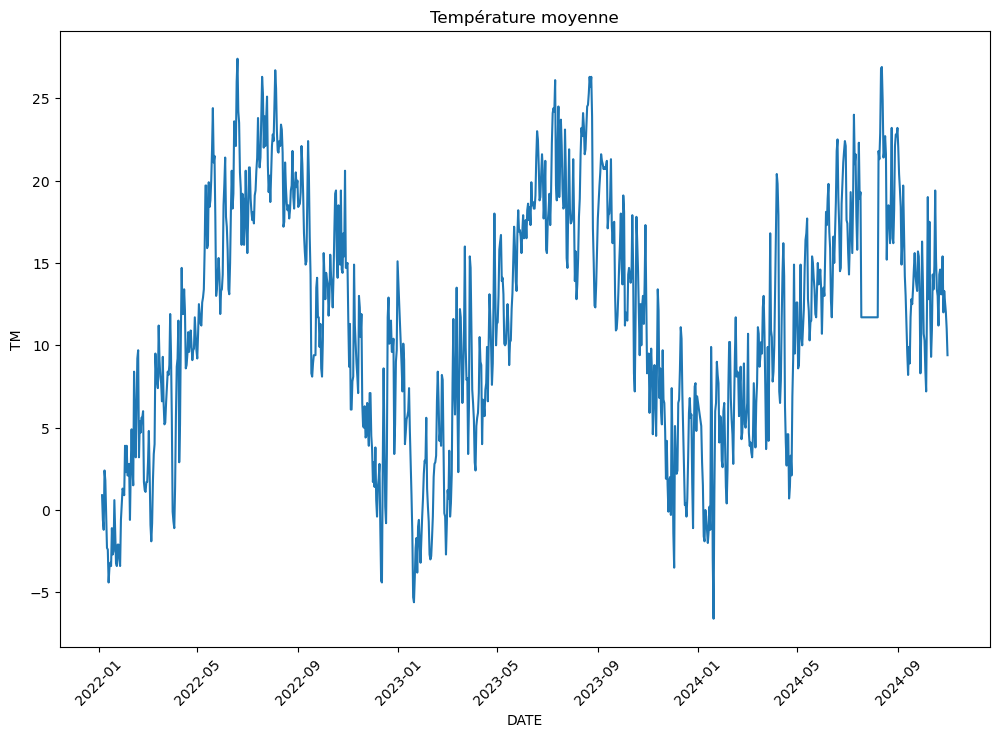

In [10]:
# Configurer la taille des images globalement
f.plt.rcParams['figure.figsize'] = [12, 8]  # Largeur, hauteur en pouces

f.sns.lineplot(x=df['DATE'], y=df['TM'])
f.plt.xticks(rotation=45)
f.plt.title("Température moyenne")
f.plt.show()

Le graphe montre clairement une série temporelle avec des fluctuations saisonnières visibles, ce qui est typique pour des données météorologiques (par exemple, température) sur une période prolongée.

Analyse rapide de la série :
Saisonnalité apparente : On observe des schémas périodiques répétitifs, probablement liés à la saisonnalité annuelle.
Tendance : Il ne semble pas y avoir de tendance linéaire marquée, mais cela peut être confirmé avec des outils statistiques.
Variabilité : Les fluctuations semblent avoir une amplitude relativement constante sur la période.

Répartition des pics :

Les trois pics suggèrent un comportement cyclique qui se répète chaque année.
Cela correspond généralement à un cycle saisonnier lié à des variations climatiques annuelles (par exemple, températures maximales en été et minimales en hiver).
Données journalières :

Puisque les données sont journalières et couvrent trois années, une périodicité de 365 jours est un bon candidat pour modéliser la saisonnalité.
Interprétation des 3 pics :

Chaque pic représente probablement une période similaire dans l'année (comme un maximum en été ou un minimum en hiver).

### b) Décomposition de la série

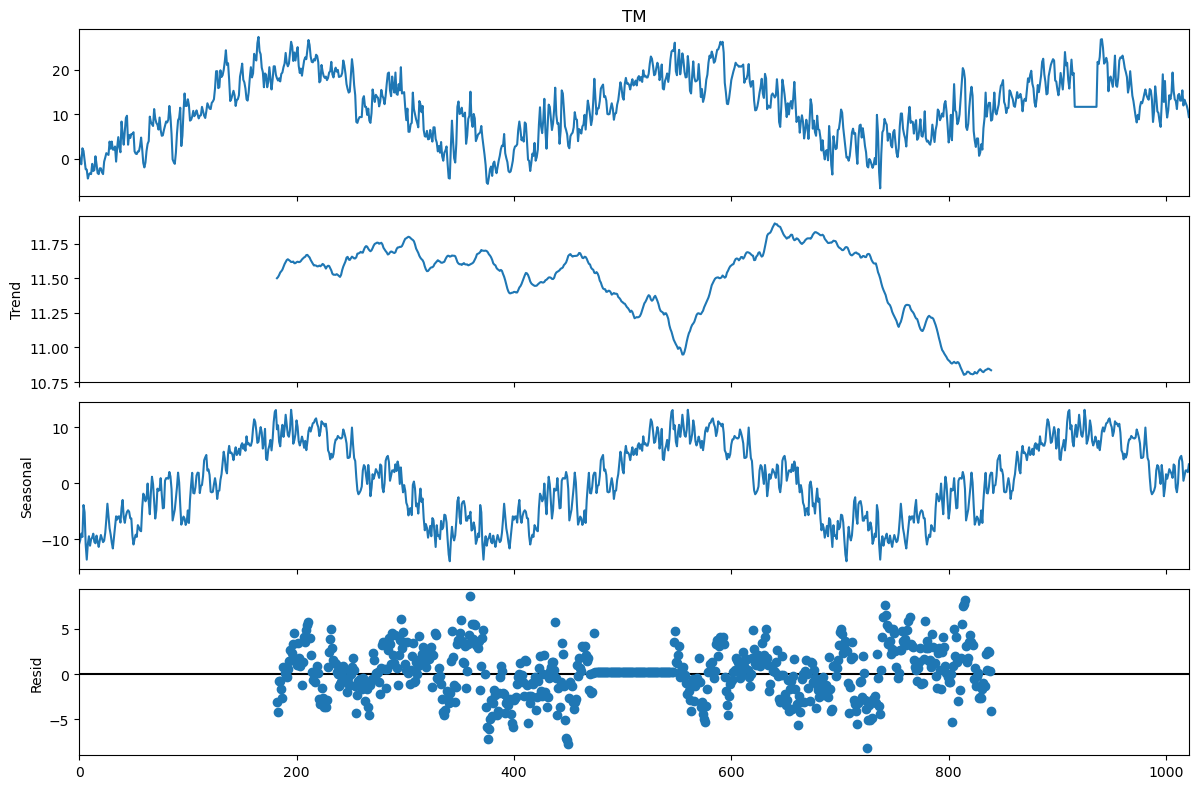

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['TM'], model='additive',  period=365)
result.plot()
f.plt.show()

L'image représente une décomposition classique d'une série temporelle en trois composantes principales : tendance, saisonnalité et résidus.

 Voici une interprétation concise de chaque composante :

 Série temporelle (TM) : Cette courbe représente l'évolution de la température moyenne dans le temps. On observe des fluctuations régulières, ce qui pourrait indiquer une influence saisonnière marquée (par exemple, les cycles annuels).

Tendance (Trend) : La tendance montre une diminution progressive de la température moyenne. Cela pourrait refléter un phénomène climatique local, tel qu'un refroidissement progressif ou des modifications dans les relevés de température au fil du temps.

Saisonnalité (Season) : La composante saisonnière met en évidence des cycles réguliers, typiques des variations climatiques saisonnières (été, hiver, etc.). Ces variations périodiques confirment l'impact des saisons sur les températures moyennes.

Résidus (Resid) : Les résidus montrent les fluctuations aléatoires qui ne sont ni expliquées par la tendance ni par la saisonnalité. Ces variations peuvent être attribuées à des événements exceptionnels, comme des vagues de chaleur, des périodes de froid inhabituelles ou des erreurs de mesure.

En résumé, cette décomposition permet d’identifier une tendance décroissante de la température moyenne, des cycles saisonniers marqués, et des variations aléatoires résiduelles. Si cette analyse fait partie d’un projet, on pourrait approfondir en testant des modèles prédictifs pour la température ou en analysant des facteurs explicatifs (comme des données environnementales ou des événements locaux).

### c) Test proprement dit

a) Test de stationnarité en cherchant le modèle approprié

In [12]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Supposons que df_standardise est déjà défini et contient la colonne 'TM'
tm = df_standardise['TM']

import pandas as pd
import statsmodels.api as sm

def regresser_modele_3(series):
    """
    Ajuste le modèle 3′ : ∆Xt = ϕXt−1 + λ + δt + εt.
    
    Arguments :
    - series : pd.Series, la série temporelle à modéliser.
    
    Retourne :
    - Résultats du modèle ajusté.
    """
    try:
        # Calculer ∆Xt (différences premières de la série)
        delta_Xt = series.diff().dropna()
        
        # Construire les variables explicatives :
        # - Xt-1 : Décalage de la série originale
        # - tendance : série croissante 0, 1, 2, ...
        Xt_minus_1 = series.shift(1).dropna()
        tendance = range(len(delta_Xt))
        
        # Créer le DataFrame des variables explicatives
        X = pd.DataFrame({"Xt-1": Xt_minus_1, "tendance": tendance})
        X = sm.add_constant(X)  # Ajouter la constante λ
        
        # Ajuster le modèle avec OLS (moindres carrés ordinaires)
        model = sm.OLS(delta_Xt, X).fit()
        
        # Afficher le résumé des résultats
        print(model.summary())
        return model
    except Exception as e:
        print(f"Erreur lors de la régression : {e}")
        return None

# Ajuster le modèle 3′
resultat = regresser_modele_3(tm)



                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     18.01
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           2.05e-08
Time:                        08:30:23   Log-Likelihood:                -395.16
No. Observations:                1021   AIC:                             796.3
Df Residuals:                    1018   BIC:                             811.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0099      0.022     -0.442      0.6

On constate que la tendance n'est pas significative. Alors, nous allons passer au modèle 2 avec constante uniquement.

In [13]:
import pandas as pd
import statsmodels.api as sm

def regresser_modele_2(series):
    """
    Ajuste le modèle 2′ : ∆Xt = ϕXt−1 + λ + εt.
    
    Arguments :
    - series : pd.Series, la série temporelle à modéliser.
    
    Retourne :
    - Résultats du modèle ajusté.
    """
    try:
        # Calculer ∆Xt (différences premières de la série)
        delta_Xt = series.diff().dropna()
        
        # Construire les variables explicatives :
        # - Xt-1 : Décalage de la série originale
        Xt_minus_1 = series.shift(1).dropna()
        
        # Créer le DataFrame des variables explicatives
        X = pd.DataFrame({"Xt-1": Xt_minus_1})
        X = sm.add_constant(X)  # Ajouter la constante λ
        
        # Ajuster le modèle avec OLS (moindres carrés ordinaires)
        model = sm.OLS(delta_Xt, X).fit()
        
        # Afficher le résumé des résultats
        print(model.summary())
        return model
    except Exception as e:
        print(f"Erreur lors de la régression : {e}")
        return None

# Exemple d'utilisation
import numpy as np

# Ajuster le modèle 2′
resultat = regresser_modele_2(tm)


                            OLS Regression Results                            
Dep. Variable:                     TM   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     35.73
Date:                Sat, 28 Dec 2024   Prob (F-statistic):           3.13e-09
Time:                        08:30:27   Log-Likelihood:                -395.32
No. Observations:                1021   AIC:                             794.6
Df Residuals:                    1019   BIC:                             804.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.011      0.105      0.9

On constate que la constante n'est pas significative. Alors, nous allons passer au modèle 1 sans constante.

In [14]:
import pandas as pd
import statsmodels.api as sm

def regresser_modele_1(series):
    """
    Ajuste le modèle 1′ : ∆Xt = ϕXt−1 + εt (sans constante).
    
    Arguments :
    - series : pd.Series, la série temporelle à modéliser.
    
    Retourne :
    - Résultats du modèle ajusté.
    """
    try:
        # Calculer ∆Xt (différences premières de la série)
        delta_Xt = series.diff().dropna()
        
        # Construire les variables explicatives :
        # - Xt-1 : Décalage de la série originale
        Xt_minus_1 = series.shift(1).dropna()
        
        # Construire le DataFrame sans constante
        X = pd.DataFrame({"Xt-1": Xt_minus_1})
        X = X.loc[delta_Xt.index]  # Aligner les index
        
        # Ajuster le modèle sans constante avec OLS
        model = sm.OLS(delta_Xt, X, hasconst=False).fit()
        
        # Afficher le résumé des résultats
        print(model.summary())
        return model
    except Exception as e:
        print(f"Erreur lors de la régression : {e}")
        return None

# Exemple d'utilisation
import numpy as np

# Ajuster le modèle 1′
resultat = regresser_modele_1(tm)



                                 OLS Regression Results                                
Dep. Variable:                     TM   R-squared (uncentered):                   0.034
Model:                            OLS   Adj. R-squared (uncentered):              0.033
Method:                 Least Squares   F-statistic:                              35.76
Date:                Sat, 28 Dec 2024   Prob (F-statistic):                    3.08e-09
Time:                        08:31:05   Log-Likelihood:                         -395.33
No. Observations:                1021   AIC:                                      792.7
Df Residuals:                    1020   BIC:                                      797.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

. Conclusion
P-valeur significative : p value < 0.05, nous rejetons H0
​
 . Le coefficient 𝜙 est négatif et significatif (𝜙 = −0.0667).

Série stationnaire :
Ces résultats indiquent que la série est stationnaire en considérant un modèle sans tendance et sans constante, car il n’y a pas de racine unitaire.

### Test complémentaire de stationnarité

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, kpss


# Test de Dickey-Fuller augmenté (ADF)
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("Test Dickey-Fuller Augmenté (ADF):")
    print(f"Statistique de test : {result[0]:.4f}")
    print(f"p-value : {result[1]:.4f}")
    print(f"Valeurs critiques : {result[4]}")
    if result[1] < 0.05:
        print("=> La série est stationnaire (on rejette l'hypothèse nulle).")
    else:
        print("=> La série n'est pas stationnaire (on ne rejette pas l'hypothèse nulle).")

# Test KPSS
def kpss_test(series):
    result = kpss(series, regression='c')
    print("\nTest KPSS:")
    print(f"Statistique de test : {result[0]:.4f}")
    print(f"p-value : {result[1]:.4f}")
    print(f"Valeurs critiques : {result[3]}")
    if result[1] > 0.05:
        print("=> La série est stationnaire (on ne rejette pas l'hypothèse nulle).")
    else:
        print("=> La série n'est pas stationnaire (on rejette l'hypothèse nulle).")

# Exécution des tests
adf_test(df_standardise["TM"])
kpss_test(df_standardise["TM"])

Test Dickey-Fuller Augmenté (ADF):
Statistique de test : -3.5260
p-value : 0.0073
Valeurs critiques : {'1%': np.float64(-3.4368090295897624), '5%': np.float64(-2.864391734279673), '10%': np.float64(-2.5682883916134824)}
=> La série est stationnaire (on rejette l'hypothèse nulle).

Test KPSS:
Statistique de test : 0.2457
p-value : 0.1000
Valeurs critiques : {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
=> La série est stationnaire (on ne rejette pas l'hypothèse nulle).


### Représentation classique de l'ACF et PACF

a) Sur la série initiale

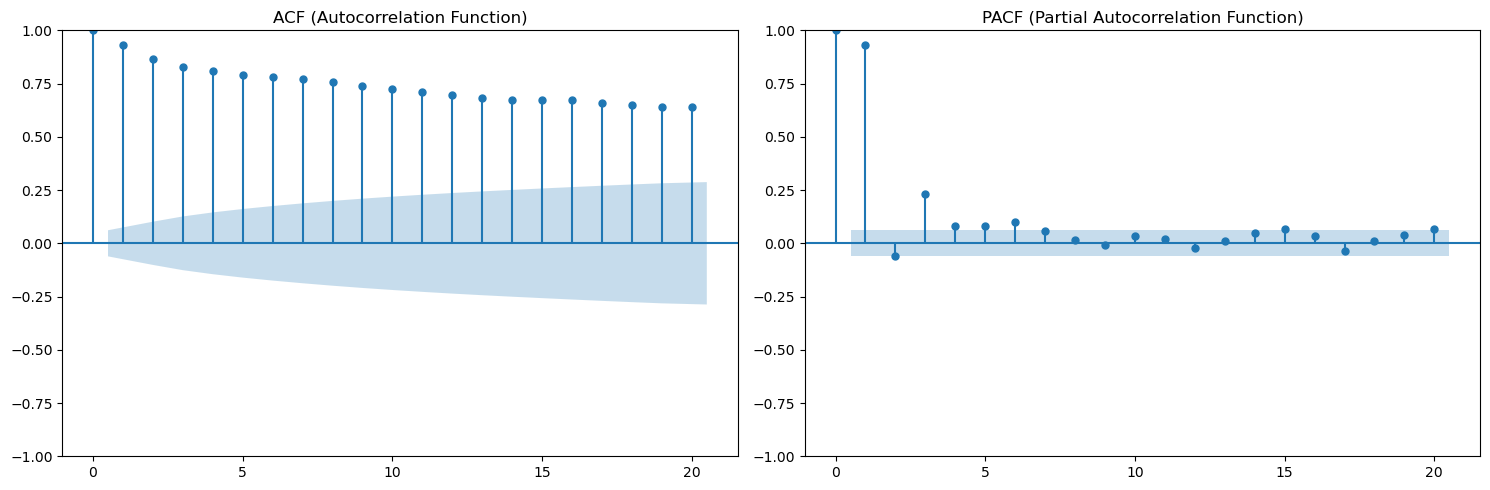

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Tracer l'ACF et le PACF
fig, axes = f.plt.subplots(1, 2, figsize=(15, 5))

# Fonction d'autocorrélation (ACF)
plot_acf(df_standardise["TM"], lags=20, ax=axes[0])
axes[0].set_title('ACF (Autocorrelation Function)')

# Fonction d'autocorrélation partielle (PACF)
plot_pacf(df_standardise["TM"], lags=20, ax=axes[1], method='ywm')
axes[1].set_title('PACF (Partial Autocorrelation Function)')

f.plt.tight_layout()
f.plt.show()

On constate que la décroissance de l'ACF est très faible,et nous n'arrivons pas vraiment à capter l'effet saisonier. Ce qui est tout à fait logique car nous avons des données journalières et la saisonalité s'étale àprès 365 lags.

b) Sur des lags plus considérables

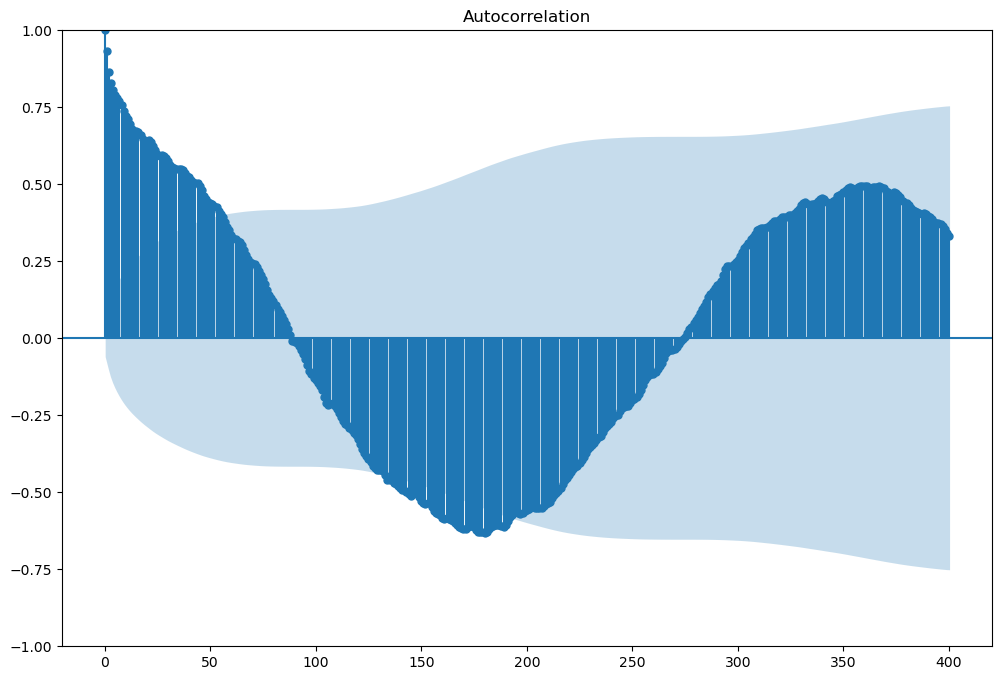

In [17]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrélation pour détecter la saisonnalité
plot_acf(df_standardise['TM'], lags=400)  # Ajustez 'lags' pour visualiser jusqu'à un cycle annuel
f.plt.show()

Interprétation du graphe ACF :
Saison régulière autour de 365 jours :

On observe un cycle clair qui diminue progressivement, puis recommence après environ 365 décalages (lags). Cela confirme une saisonnalité annuelle dans vos données (comme anticipé).
Les sommets répétés aux multiples de 365 (ou proches) indiquent que la série est influencée par un effet saisonnier avec une période annuelle.

Diminution progressive des corrélations :

La décroissance lente de l'autocorrélation suggère une tendance persistante ou une non-stationnarité. Cela confirme le besoin de différenciation (au moins D=1) pour rendre la série stationnaire.
Signes de saisonnalité :

Outre la saisonnalité annuelle principale (365 jours), il est possible qu'il y ait des sous-saisonnalités ou des cycles plus courts (par exemple, hebdomadaires ou mensuels), mais ils ne sont pas immédiatement apparents ici.

### Détermination de la valeur de p et q : ACF et PACF en appliquant le modèle 1

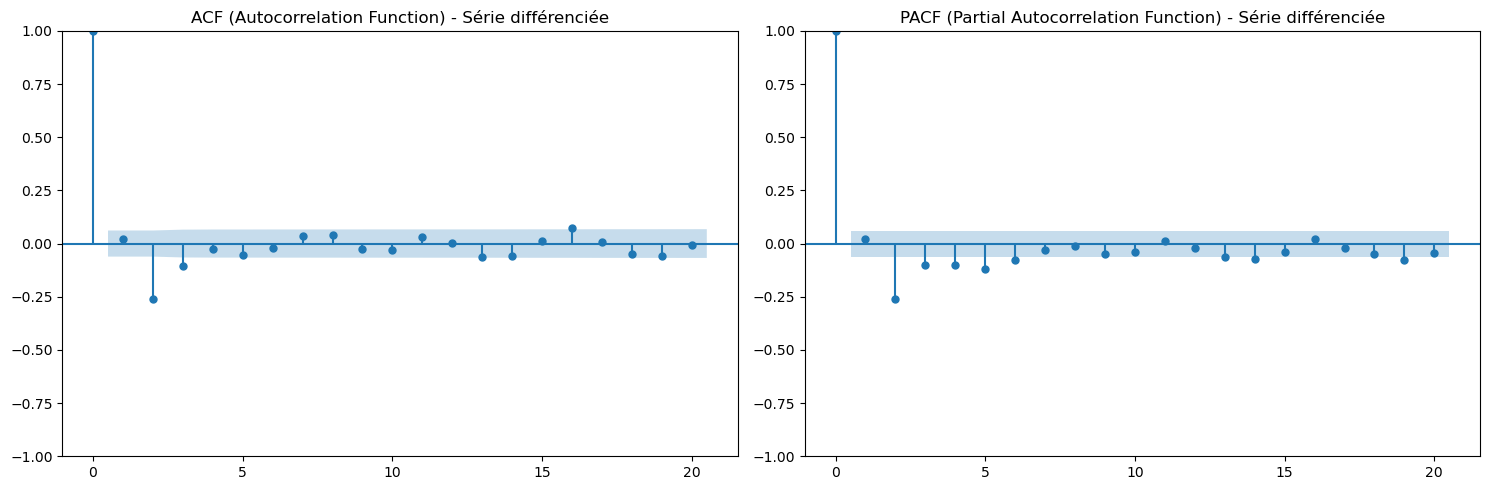

In [18]:
import matplotlib.pyplot as plt

# Calculer la série différenciée (Delta X_t)
tm_diff = df_standardise["TM"].diff().dropna()  # Différence première

# Tracer l'ACF et le PACF de la série différenciée
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Fonction d'autocorrélation (ACF)
plot_acf(tm_diff, lags=20, ax=axes[0])
axes[0].set_title('ACF (Autocorrelation Function) - Série différenciée')

# Fonction d'autocorrélation partielle (PACF)
plot_pacf(tm_diff, lags=20, ax=axes[1], method='ywm')  # "ywm" est robuste
axes[1].set_title('PACF (Partial Autocorrelation Function) - Série différenciée')

f.plt.tight_layout()
f.plt.show()


Pour analyser les différents modèles possibles en fonction des graphiques ACF et PACF, nous utilisons les concepts des modèles ARIMA (p,d,q) où p est l'ordre autorégressif, d est le degré de différenciation, et q est l'ordre du modèle de moyenne mobile.

Dans votre cas :
La série a déjà été différenciée une fois, donc d=1.

Les graphiques ACF et PACF permettent d'identifier les valeurs possibles de p (pour la partie autorégressive AR) et q (pour la partie moyenne mobile MA).

Analyse des valeurs possibles de p et 𝑞

1. Modèle autorégressif (AR) : ACF et PACF
Le PACF montre un pic significatif uniquement au lag 1, ce qui indique un modèle AR(1).
Valeur possible de p : p=1.
D'autres valeurs de p>1 sont peu probables, car les pics au-delà du lag 1 dans la PACF ne sont pas significatifs.

2. Modèle de moyenne mobile (MA) : ACF et PACF
L'ACF diminue rapidement après le lag 1, ce qui est caractéristique d'un modèle AR ou éventuellement d'une faible composante MA.
Valeur possible de q=0 (pas de terme MA significatif).

Une faible composante q=1 pourrait être envisagée si des résidus présentent un certain bruit blanc.

Différents modèles possibles :
En tenant compte de d=1 (série différenciée), les modèles possibles sont :

ARIMA(1, 1, 0) : Un modèle AR(1) sur la série différenciée, cohérent avec votre modèle initial.
ARIMA(1, 1, 1) : Si une petite composante MA est détectée dans les résidus.
​ARIMA(0, 1, 1) : Si l'AR(1) est moins dominant mais une composante MA est présente.
Ici, seule l'ACF serait significative.
ARIMA(0, 1, 0) : Si la série est un bruit blanc différencié (peu probable ici car 𝜙semble significatif).

Résumé :
Les modèles probables : ARIMA(1, 1, 0) ou ARIMA(1, 1, 1). Le choix final dépendra de tests statistiques comme le critère AIC/BIC et l'analyse des résidus.
Si vous souhaitez approfondir l'identification du modèle ou valider les résidus, je peux vous guider dans cette analyse.

### Modélisation

Modèle SARIMA :

En tenant compte de la saisonnalité annuelle, un modèle SARIMA serait pertinent :
SARIMA(1, 1, 0) × (1, 1, 0, 365) ou
SARIMA(1, 1, 1) × (1, 1, 0, 365).


#### Code de manière générale pour les SARIMA

In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Fonction pour ajuster un modèle SARIMA et afficher les résultats
def fit_sarima_model(df, order, seasonal_order, model_name=""):
    print(f"\n### Modèle {model_name} : SARIMA{order} × {seasonal_order} ###")
    
    # Ajuster le modèle
    model = SARIMAX(df["TM"], order=order, seasonal_order=seasonal_order)
    results = model.fit(disp=False, method="lbfgs")
    
    # Résumé du modèle
    print(results.summary())
    
    # Critères AIC et BIC
    aic = results.aic
    bic = results.bic
    print(f"\nCritères : AIC = {aic:.2f}, BIC = {bic:.2f}")
    
    # Résidus du modèle
    residuals = results.resid
    
    # Visualisation des résidus
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(residuals, label="Résidus")
    plt.axhline(0, linestyle="--", color="gray")
    plt.legend()
    plt.title("Résidus")
    plt.subplot(2, 1, 2)
    plot_acf(residuals, lags=50, ax=plt.gca())
    plt.title("ACF des résidus")
    plt.tight_layout()
    plt.show()
    
    # Vérification si les résidus sont du bruit blanc
    print("\nTest des résidus :")
    print("Moyenne des résidus :", np.mean(residuals))
    print("Variance des résidus :", np.var(residuals))
    
    # Prédictions dans la période d'entraînement
    fitted_values = results.fittedvalues
    
    # Calcul des erreurs (RMSE, MAE)
    rmse = np.sqrt(mean_squared_error(df["TM"], fitted_values))
    mae = mean_absolute_error(df["TM"], fitted_values)
    print(f"RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    
    # Visualisation des valeurs observées vs prédites
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df["TM"], label="Valeurs observées", color="blue")
    plt.plot(df.index, fitted_values, label="Valeurs prédites", color="red", linestyle="--")
    plt.xlabel("Date")
    plt.ylabel("TM")
    plt.title("Valeurs observées vs Valeurs prédites")
    plt.legend()
    plt.show()
    
    return results, aic, bic, rmse, mae

a) SARIMA(1, 1, 0) × (1, 1, 0, 365)

- Sur le train


### Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 0, 12) ###
                                     SARIMAX Results                                      
Dep. Variable:                                 TM   No. Observations:                  817
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -483.771
Date:                            Sat, 28 Dec 2024   AIC                            973.541
Time:                                    08:31:37   BIC                            987.610
Sample:                                         0   HQIC                           978.944
                                            - 817                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0572      0.034

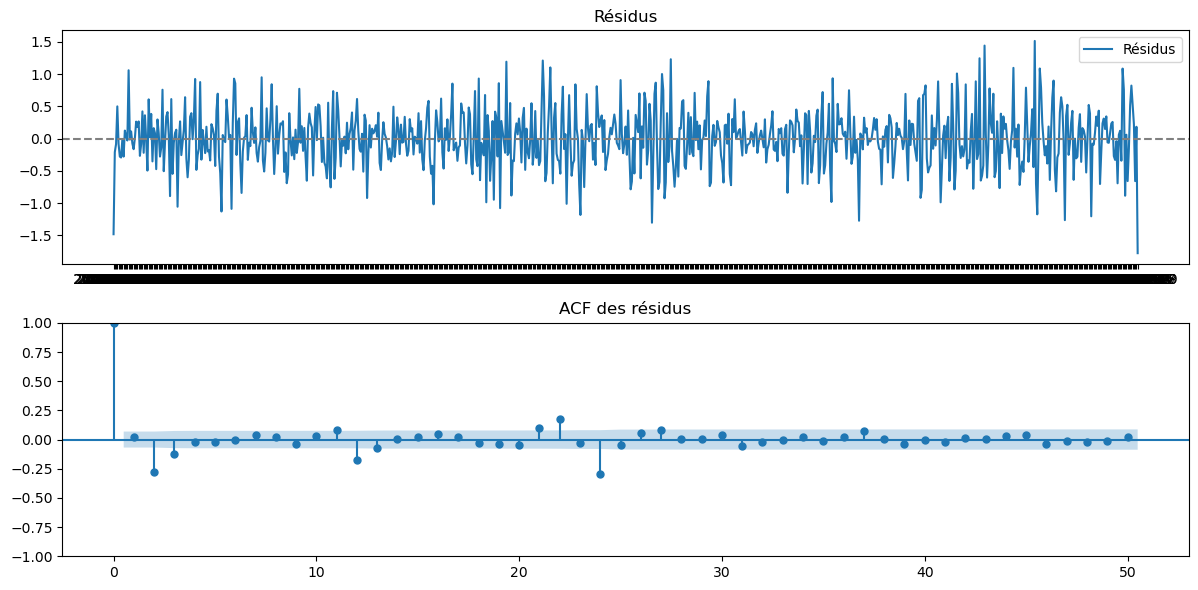


Test des résidus :
Moyenne des résidus : -0.0012678261513359628
Variance des résidus : 0.19598449625769934
RMSE = 0.4427, MAE = 0.3408


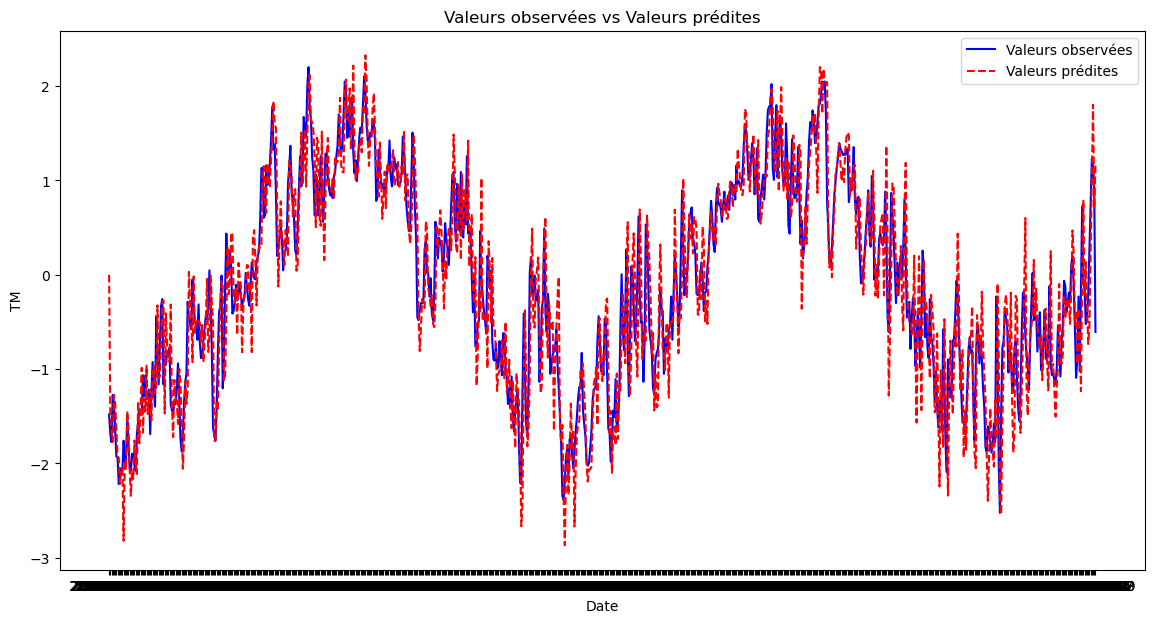

In [20]:
# Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12)
order_1 = (1, 1, 0)
seasonal_order_1 = (1, 1, 0, 12)
results_1, aic_1, bic_1, rmse_1, mae_1 = fit_sarima_model(
    train, order_1, seasonal_order_1, "SARIMA(1, 1, 0) × (1, 1, 0, 12)"
)

- Sur le test


### Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 0, 12) ###
                                     SARIMAX Results                                      
Dep. Variable:                                 TM   No. Observations:                  205
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -118.789
Date:                            Sat, 28 Dec 2024   AIC                            243.579
Time:                                    08:32:04   BIC                            253.351
Sample:                                04-10-2024   HQIC                           247.536
                                     - 10-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0278      0.073

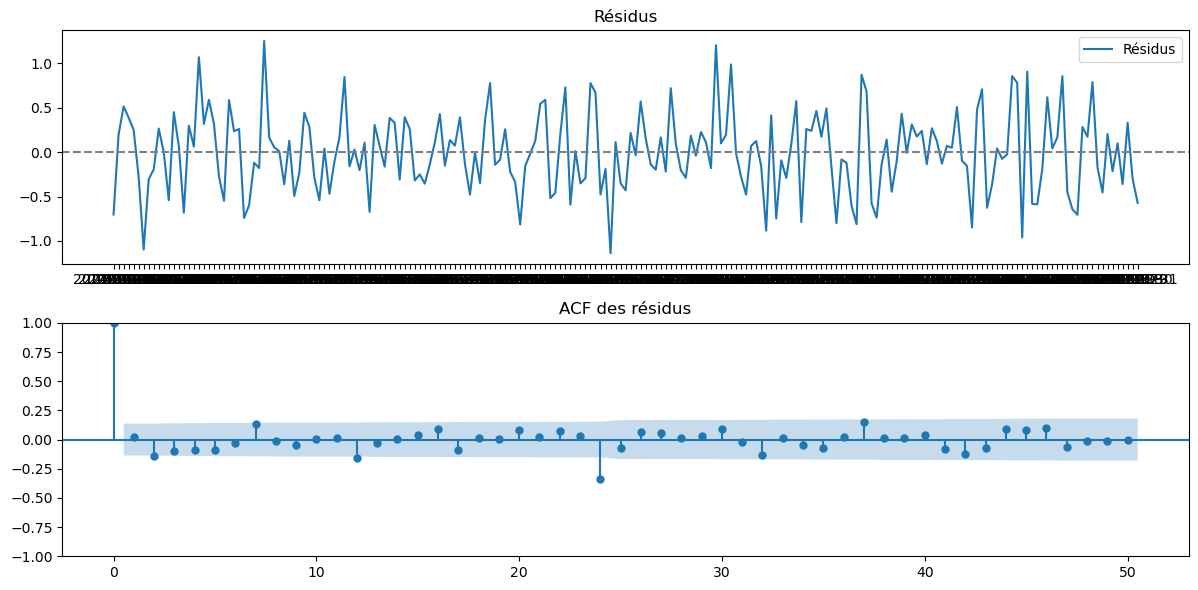


Test des résidus :
Moyenne des résidus : -0.00450362272884995
Variance des résidus : 0.20388172452308495
RMSE = 0.4516, MAE = 0.3596


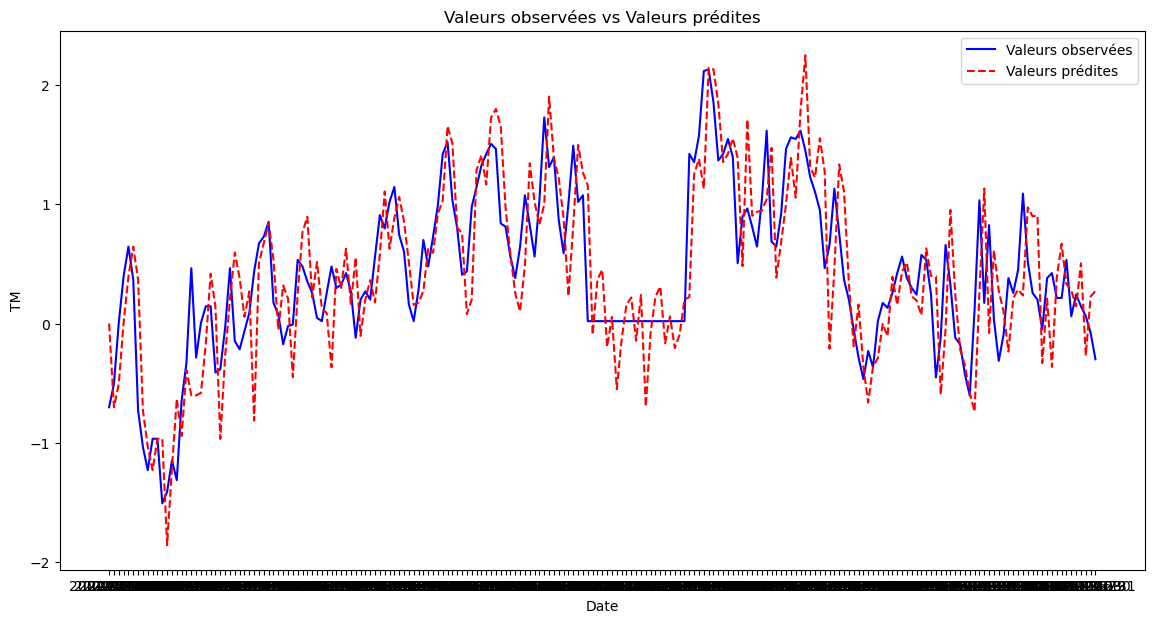

In [21]:
# Modèle SARIMA(1, 1, 0) × (1, 1, 0, 12)
order_1 = (1, 1, 0)
seasonal_order_1 = (1, 1, 0, 12)
results_1, aic_1, bic_1, rmse_1, mae_1 = fit_sarima_model(
    test, order_1, seasonal_order_1, "SARIMA(1, 1, 0) × (1, 1, 0, 12)"
)

b) SARIMA(1, 1, 1) × (1, 1, 0, 365)

- Sur le train


### Modèle SARIMA(1, 1, 1) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 1, 12) ###
                                      SARIMAX Results                                       
Dep. Variable:                                   TM   No. Observations:                  817
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -351.876
Date:                              Sat, 28 Dec 2024   AIC                            711.752
Time:                                      08:32:32   BIC                            730.510
Sample:                                           0   HQIC                           718.956
                                              - 817                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

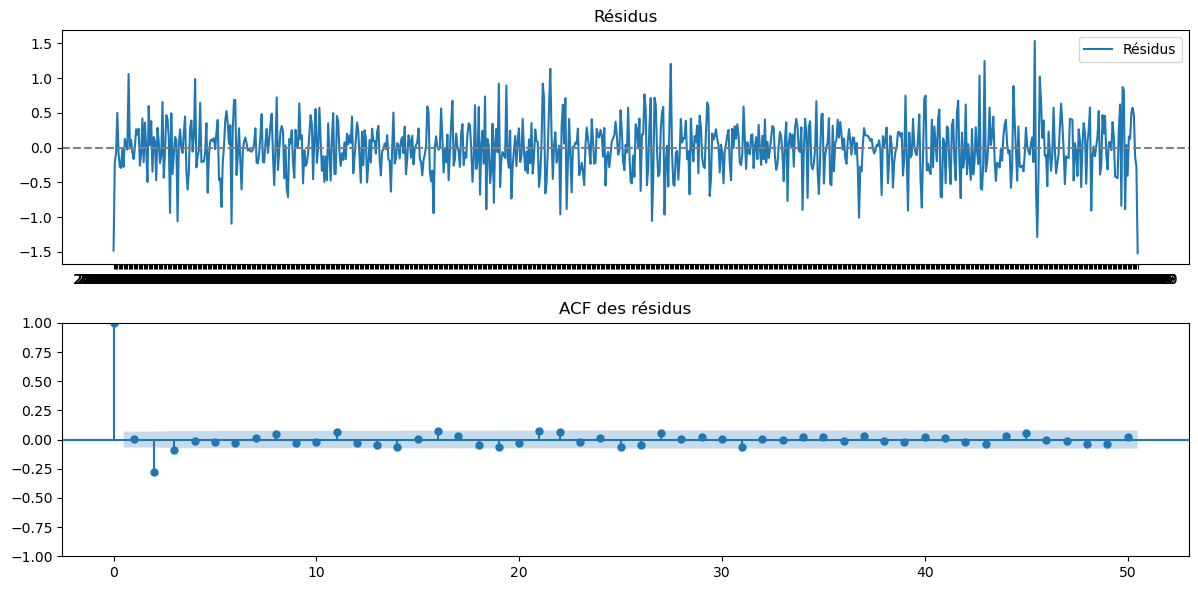


Test des résidus :
Moyenne des résidus : -0.0041138854653597805
Variance des résidus : 0.14154586643317743
RMSE = 0.3762, MAE = 0.2880


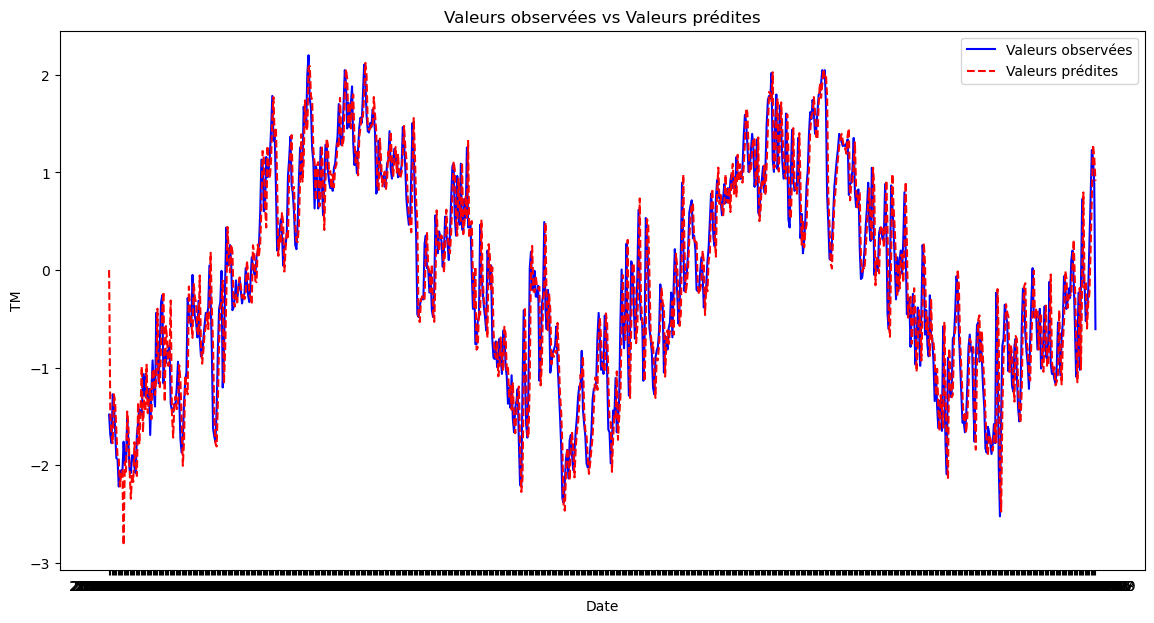

In [22]:
# Modèle SARIMA(1, 1, 1) × (1, 1, 0, 365)
order_2 = (1, 1, 0)
seasonal_order_2 = (1, 1, 1, 12)
results_2, aic_2, bic_2, rmse_2, mae_2 = fit_sarima_model(
    train, order_2, seasonal_order_2, "SARIMA(1, 1, 1) × (1, 1, 0, 12)"
)

- Sur le test


### Modèle SARIMA(1, 1, 1) × (1, 1, 0, 12) : SARIMA(1, 1, 0) × (1, 1, 1, 12) ###
                                      SARIMAX Results                                       
Dep. Variable:                                   TM   No. Observations:                  205
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 -94.806
Date:                              Sat, 28 Dec 2024   AIC                            197.611
Time:                                      08:33:03   BIC                            210.641
Sample:                                  04-10-2024   HQIC                           202.889
                                       - 10-31-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0

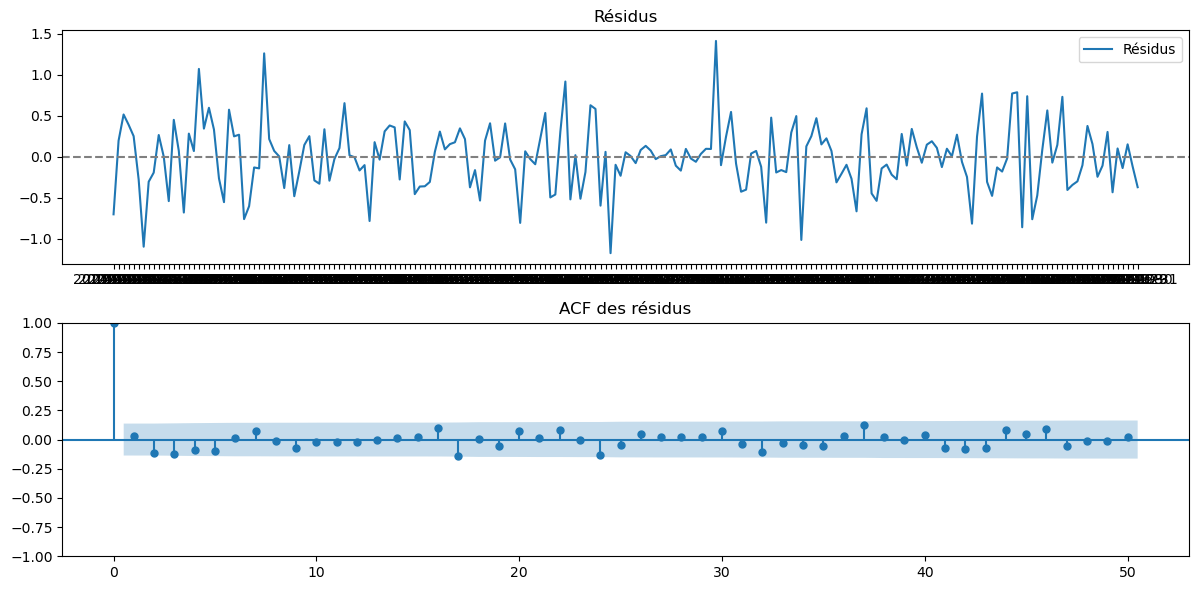


Test des résidus :
Moyenne des résidus : -0.007492554511611313
Variance des résidus : 0.1630838261437544
RMSE = 0.4039, MAE = 0.3067


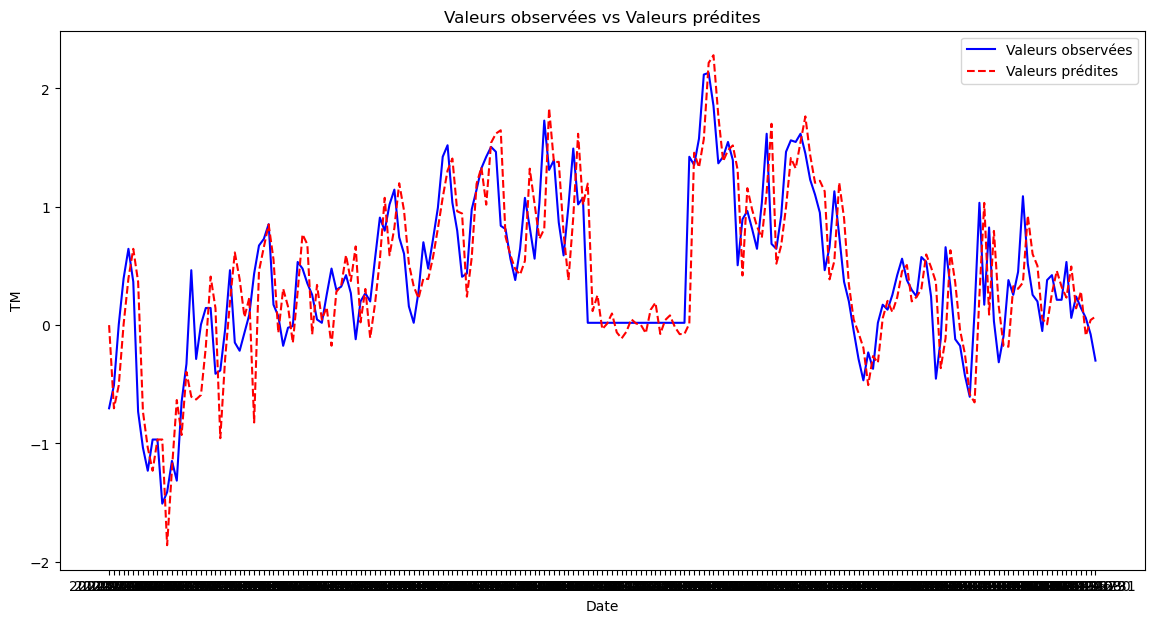

In [23]:
# Modèle SARIMA(1, 1, 1) × (1, 1, 0, 12)
order_2 = (1, 1, 0)
seasonal_order_2 = (1, 1, 1, 12)
results_2, aic_2, bic_2, rmse_2, mae_2 = fit_sarima_model(
    test, order_2, seasonal_order_2, "SARIMA(1, 1, 1) × (1, 1, 0, 12)"
)

c) Comparaison des modèles

In [ ]:
# Comparaison des modèles
#print("\n### Comparaison des modèles ###")
#print(f"SARIMA(1, 1, 0) × (1, 1, 0, 365) : AIC = {aic_1:.2f}, BIC = {bic_1:.2f}, RMSE = {rmse_1:.4f}, MAE = {mae_1:.4f}")
#print(f"SARIMA(1, 1, 1) × (1, 1, 0, 365) : AIC = {aic_2:.2f}, BIC = {bic_2:.2f}, RMSE = {rmse_2:.4f}, MAE = {mae_2:.4f}")

#if aic_1 < aic_2 and rmse_1 < rmse_2:
    #print("\nLe modèle SARIMA(1, 1, 0) × (1, 1, 0, 365) est préférable.")
#else:
    #print("\nLe modèle SARIMA(1, 1, 1) × (1, 1, 0, 365) est préférable.")

# *2) Modélisation par réseau de neuronnes simple*

### Visualisation de toutes les variables

In [ ]:
# Visualizing the behavior of all columns
columns = df.drop(columns=['DATE']).columns
for column in columns:
    f.sns.lineplot(x=df['DATE'], y=df[column])
    f.plt.title(column)
    f.plt.show()

In [26]:
# Fonction pour convertir notre base de données en une base de time series:
def create_window(target, feature, window=1, offset=0):
    feature_new, target_new = [], []
    feature_np = feature.to_numpy()
    target_np = target.to_numpy()
    for i in range(window, target.shape[0] - offset):
        feature_list = feature_np[i - window:i]
        feature_new.append(feature_list.reshape(window, feature_np.shape[1]))
        target_new.append(target_np[i+offset].reshape(1))
    return np.array(feature_new), np.array(target_new)

In [32]:
# Function to create train and test datasets
def train_test(feature, target, perc_train = 0.8):
    size_train = int(len(feature) * perc_train)

    x_train = feature[0:size_train]
    y_train = target[0:size_train]

    x_test = feature[size_train: len(feature)]
    y_test = target[size_train: len(feature)]

    return x_train, x_test, y_train, y_test

Nous avons ici une fonction pour créer l'ensemble de données d'entraînement et de test. Nous utilisons une fonction personnalisée car nous voulons séparer l'ensemble de données sans aucun mélange, juste une coupe nette, afin de pouvoir conserver la caractéristique temporelle des données

Après analyse de l'autocorrelation entre les variables de la base et par anticipation du risque de multicolinéarité ou d'endogénéité, les variables choisies pour la modélisation sont:
'RR', 'HTN', 'DG', 'TAMPLI','FFM', 'FXI', 'DXI', 'HXI', 'FXY', 'DXY', 'HXY', 'FXI3S', 'HXI3S', 'UN','HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80', 'TSVM', 'UM', 'ETPGRILLE','NEIGETOTX', 'NEIGETOT06'

In [139]:
# scale all the dataset (not including the date)
scaler = f.StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns='DATE'))
df_scaled = f.pd.DataFrame(df_scaled, columns=df.drop(columns='DATE').columns)

# Set the window to 10
window = 10
feature_columns = ['RR', 'HTN', 'DG', 'TAMPLI',
       'FFM', 'FXI', 'DXI', 'HXI', 'FXY', 'DXY', 'HXY', 'FXI3S', 'HXI3S', 'UN',
       'HUN', 'UX', 'HUX', 'DHUMI40', 'DHUMI80', 'TSVM', 'UM', 'ETPGRILLE',
       'NEIGETOTX', 'NEIGETOT06']

# Create a window with all the columns as features (excluding the date)
feature, target = create_window(df_scaled['TM'],df_scaled[feature_columns], window=window)
print(feature[0])
print(target[0])
print(df_scaled.head(12))

[[-1.45555566e-01  1.40001758e+00  8.34363864e-01 -1.52458447e+00
   6.03369147e-01 -7.46105629e-02  9.78041010e-01 -1.06665514e+00
   3.34492734e-01  1.20920809e+00 -4.98220526e-01  3.32505020e-02
  -1.06396840e+00  7.60913731e-01 -2.02201216e-02  4.23006718e-01
  -5.20901580e-01 -4.88202398e-01  9.55055047e-01 -1.25716261e+00
   9.00249163e-01 -1.12346998e+00 -1.36105786e-01 -1.24370697e-01]
 [-5.10261131e-01  1.38118879e+00  2.70707050e+00 -1.02468863e+00
   2.81865879e-01 -2.27208077e-02  9.78041010e-01  1.99264271e-01
   5.01466802e-01  1.20920809e+00  1.93693996e-01  6.35645190e-02
   2.03431801e-01  1.05151681e+00 -5.73652717e-01  4.23006718e-01
   2.11202990e+00 -4.88202398e-01  6.34599229e-01 -1.40751018e+00
   9.00249163e-01 -1.00935316e+00 -1.36105786e-01 -1.24370697e-01]
 [ 8.92452579e-01 -1.07733341e-01  1.76257498e+00 -7.41414327e-01
  -6.82643926e-01 -9.30791524e-01 -9.08362221e-01  2.01361132e+00
  -9.45641784e-01 -5.72525861e-01  2.08746616e+00 -9.67112058e-01
   2.019

Nous avons ici notre première série temporelle, utilisant toutes les colonnes choisies et avec une fenêtre de 10.

<Axes: xlabel='DATE'>

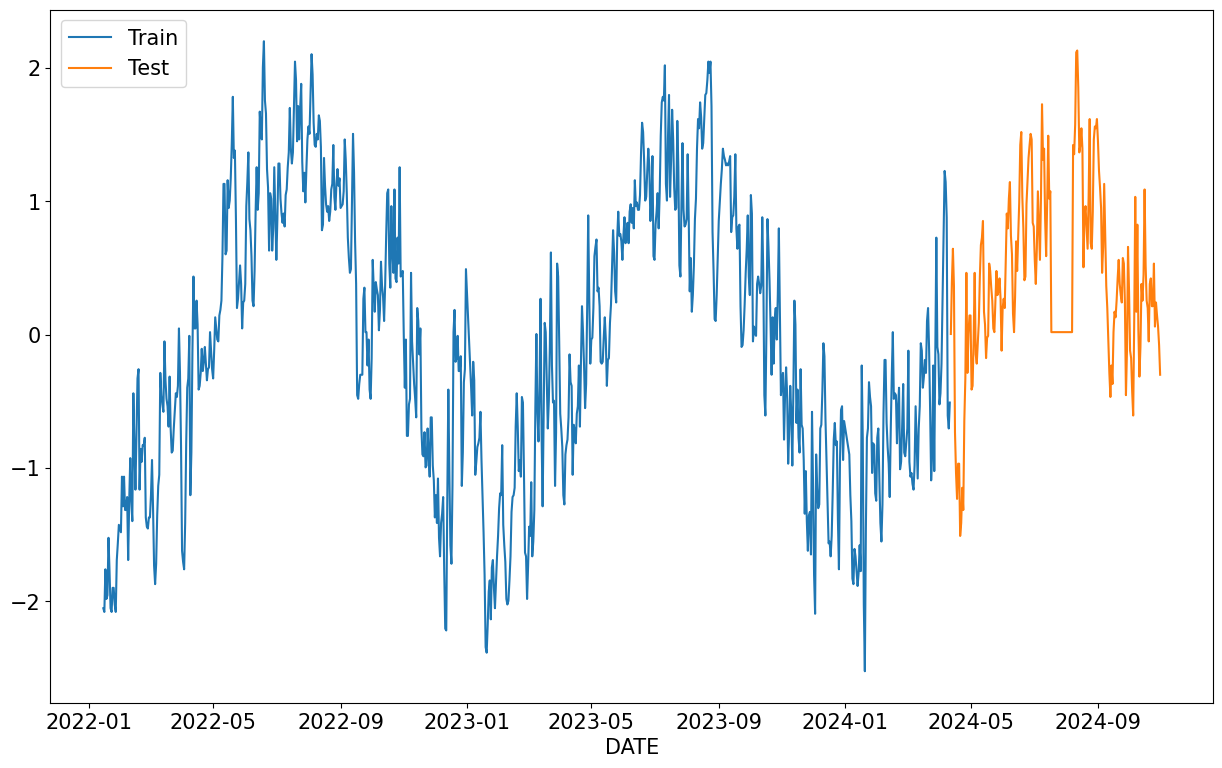

In [140]:
x_train, x_test, y_train, y_test = train_test(feature, target)

# Visualize the train and test data
f.sns.lineplot(x=df['DATE'].iloc[window:len(y_train) + window], y=y_train[:,0], label='Train')
f.sns.lineplot(x=df['DATE'].iloc[window + len(y_train):], y=y_test[:,0], label='Test')

# **Prediction**

## *a)En utilisant les autres variables*

Pour ce test de cas, nous utiliserons toutes les fonctionnalités de notre série temporelle

In [141]:
# Creation d'un modèle de réseau de neuronnes simples
def model_lstm(x_shape):

    model = keras.Sequential()
    model.add(keras.layers.LSTM(64, input_shape=(x_shape[1], x_shape[2])))
    model.add(keras.layers.Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer='RMSProp')
    return model

Nous créons un modèle simple car notre ensemble de données n'est pas trop complexe, donc un simple réseau neuronal fera l'affaire.

Et nous créons cette fonction car nous utilisons ce même modèle après.

In [142]:
model = model_lstm(x_train.shape)
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,849 (89.25 KB)

 Trainable params: 22,849 (89.25 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5415 - val_loss: 0.2883
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1820 - val_loss: 0.2429
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1635 - val_loss: 0.2081
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1364 - val_loss: 0.1984
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1271 - val_loss: 0.1933
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1255 - val_loss: 0.1769
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0971 - val_loss: 0.1669
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0915 - val_loss: 0.1727
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0901 - val_loss: 0.1705
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0908 - val_loss: 0.1605
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0713 - val_loss: 0.1630
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

Compte tenu de la perte, notre solution est plutôt bonne !

In [144]:
# Function to print the results of the fit process
def print_loss(result):
    f.plt.plot(result.history['loss'])
    f.plt.plot(result.history['val_loss'])
    f.plt.legend(['Train', 'Test'])
    f.plt.xlabel('Epochs')
    f.plt.ylabel('Cost')
    f.plt.show()


# Function to print the y_predicted compared with the y_test
def print_test_x_prediction(y_test, y_predict, df_date, train_size, window=0):
    f.sns.lineplot(x=df_date.iloc[train_size + window:], y=y_test[:,0], label = 'Test')
    f.sns.lineplot(x=df_date.iloc[train_size + window:], y=y_predict[:,0], label = 'Predict')
    f.plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


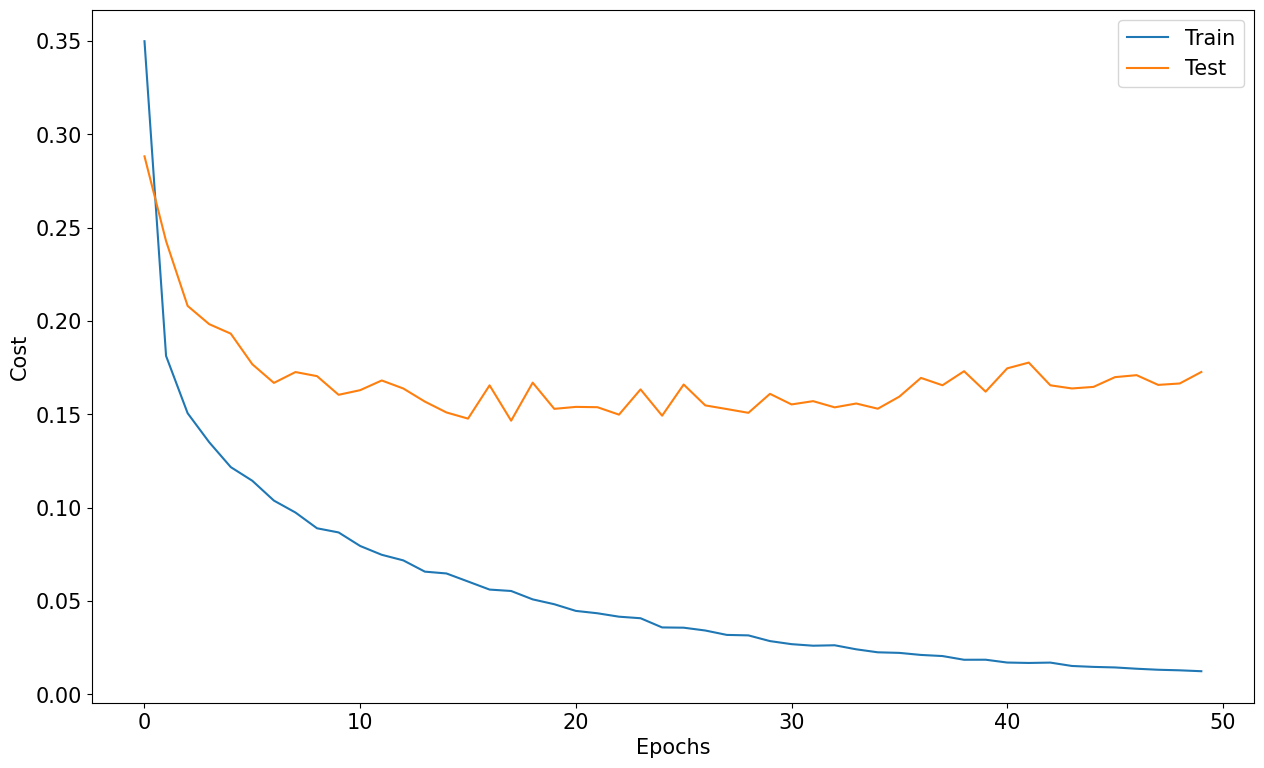

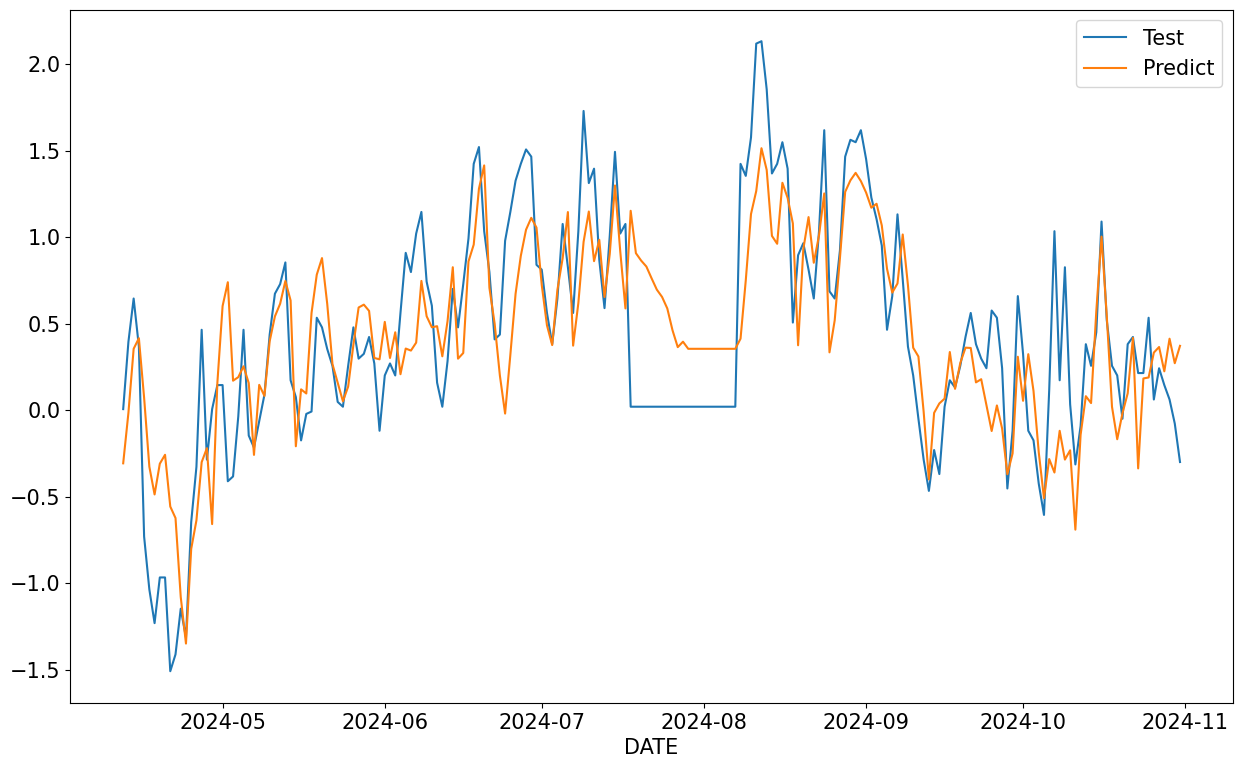

In [145]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['DATE'], len(y_train), window=window)

On remarque qu'en utilisant toutes les autres variables, on remarque que la prédiction est plutôt bonne mais peut-être améliorée.

## *b)En utilisant seulement la température moyenne: la variable cible*

Ici, nous utiliserons simplement la variable cible de notre série temporelle et ignorerons toutes les autres fonctionnalités.

In [146]:
feature, target = create_window(df_scaled['TM'], df_scaled[['TM']], window=10)

x_train, x_test, y_train, y_test = train_test(feature, target)

model = model_lstm(x_train.shape)
result = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=50)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.7881 - val_loss: 0.3100
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2668 - val_loss: 0.2844
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2091 - val_loss: 0.2452
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2110 - val_loss: 0.2278
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2011 - val_loss: 0.2515
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1891 - val_loss: 0.1962
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1786 - val_loss: 0.1887
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1733 - val_loss: 0.1872
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1585 - val_loss: 0.1649
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1515 - val_loss: 0.1618
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1599 - val_loss: 0.1426
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1

1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


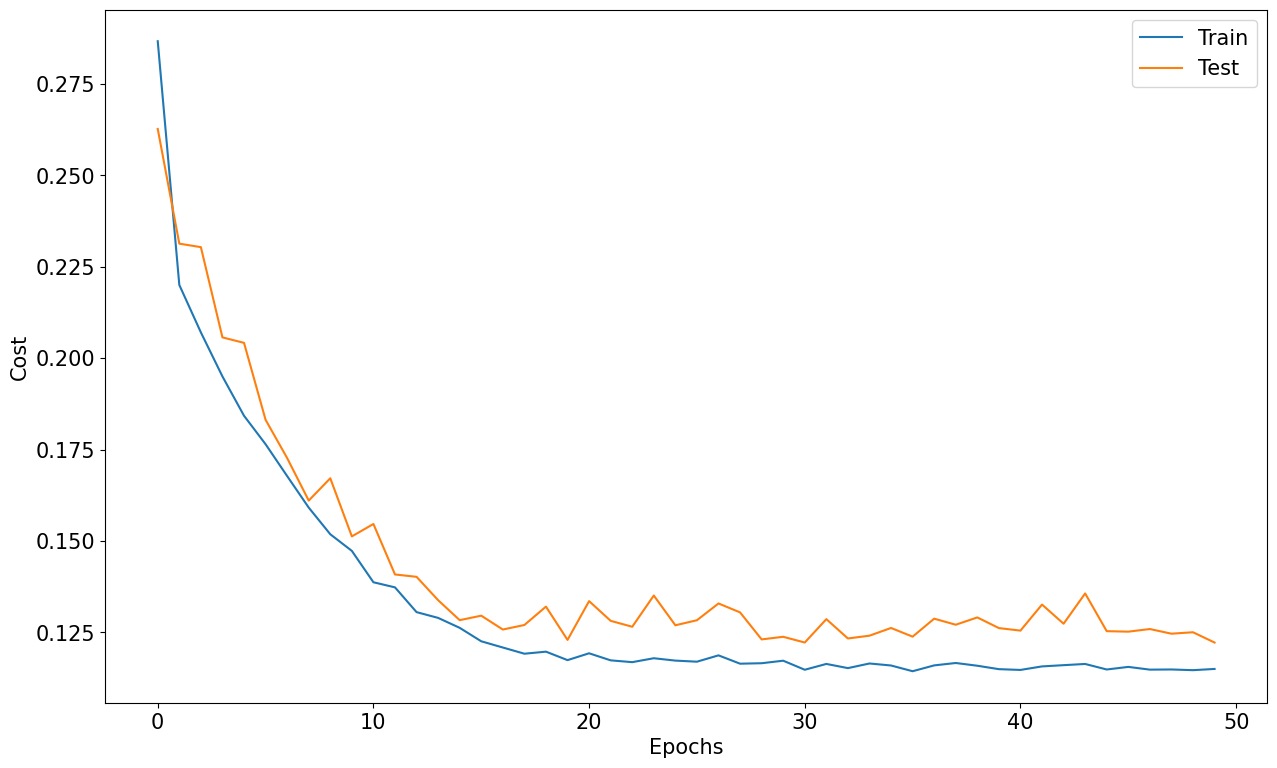

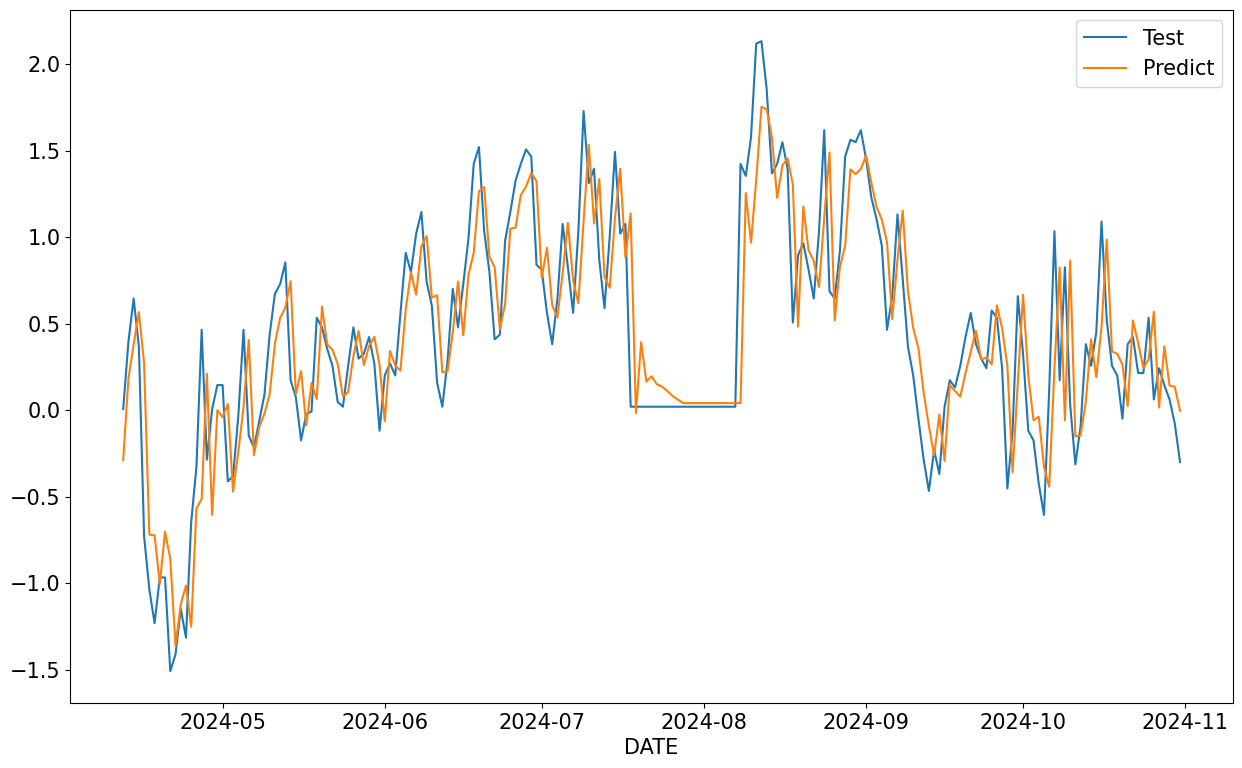

In [79]:
y_predict = model.predict(x_test)

print_loss(result)
print_test_x_prediction(y_test, y_predict, df['DATE'], len(y_train), window=window)

Il semble que cette solution ait eu un meilleur résultat que la dernière, pas pour beaucoup, mais c'est une différence.

Cela se produit probablement parce que nous avons un ensemble de données simple, et que la température de la veille suffit déjà à faire une bonne prédiction, les autres fonctionnalités ne font que perturber le modèle plus qu'elles ne l'aident, donc moins c'est plus dans ce cas !

# *2)Régression linéaire multiple*

In [126]:
print("Shape of X_train:", x_train.shape)
print("Shape of X_test:", x_test.shape)

Shape of X_train: (809, 10)
Shape of X_test: (203, 10)


In [127]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) 
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
print("Shape of X_train:", x_train.shape)
print("Shape of X_test:", x_test.shape)

Shape of X_train: (809, 10)
Shape of X_test: (203, 10)


Mean Squared Error (MSE): 0.12607187119359356
R-squared (R²): 0.7065858789192729


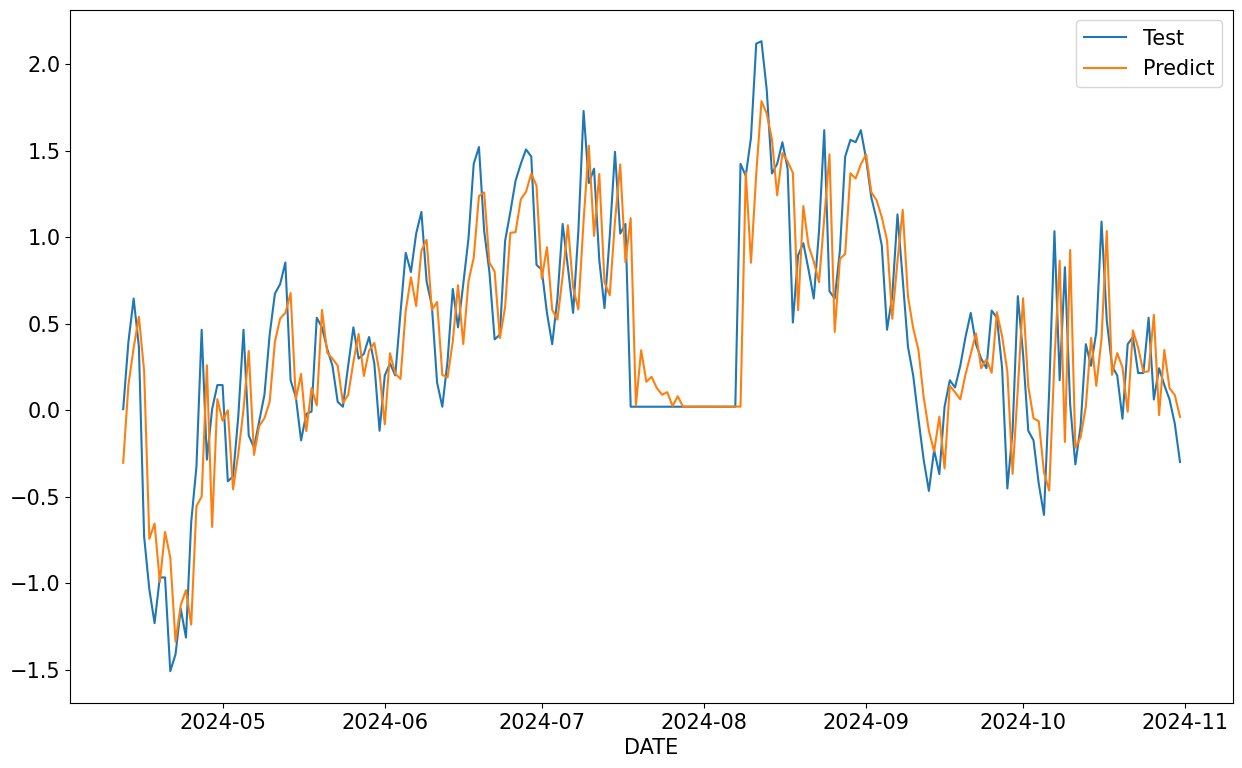

In [128]:
model_linear_reg = LinearRegression().fit(x_train, y_train)
y_predict = model_linear_reg.predict(x_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

print_test_x_prediction(y_test, y_predict, df['DATE'], len(y_train), window=window)

Cela prouve que les séries chronologiques sont très puissantes même lorsqu'elles ne sont pas utilisées avec leur algorithme le plus connu

# *3) Modélisation avec Random Forest*

Le Random Forest est un algorithme d'apprentissage automatique supervisé, largement utilisé pour les tâches de classification et de régression.

In [12]:
conda install python-graphviz

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [13]:
#on divise la base en partie test et en partie entraînement
data= f.pd.read_csv("base.csv", index_col =["DATE"])
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# On divisie la base train en une partie contenant les variables explicatives et la variable d'interêt
x_train=train.drop('TM',axis=1)
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test=test.drop('TM',axis=1)
TM_test=test['TM']

Les statistiques descriptives ont montré de fortes corrélations entre la variable d'études "TM": Température moyenne et les autres variables liées à la température telles que "TN": température minimale, "TX": Température maximale,"TAMPLI": Amplitude thermique(écart entre température maximale et miniamle), "TNTXM": Moyenne de la température minimale et maximale sur une période donnée,"TMNX": Moyenne des températures minimales et maximales,"TSVM": Température moyenne au sol.

In [14]:
# On divisie la base train en une partie contenant les variables explicatives et la variable d'interêt et on supprime les variables de températures
x_train2=train.drop(columns=['TMNX', 'TNTXM','TM',"TX","TN","TAMPLI","TSVM"])
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test2=test.drop(columns=['TMNX', 'TNTXM','TM',"TX","TN","TAMPLI","TSVM"])
TM_test=test['TM']


In [15]:
x_train2.shape,x_test2.shape,TM_train.shape,TM_test.shape

((817, 23), (205, 23), (817,), (205,))

In [16]:
#recherche des meilleurs paramètres 
param_dist = {'n_estimators': f.randint(50,500),# il s’agit du nombre d’arbres dans la forêt
              'max_depth': f.randint(1,20)}#il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)

# Creation d'un random forest classifier
rf = f.RandomForestRegressor()

# Utilisation de random search pour trouver les meilleurs paramètres
rand_search = f.RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit le random search object avec la data
rand_search.fit(x_train2, TM_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f65e86b2d80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f65e912fc80>})

In [17]:
# Création d'une variable pour le meilleur modèle
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 450}


In [18]:
#On réalise ainsi la regression
rf2=f.RandomForestRegressor(max_depth=rand_search.best_params_["max_depth"], n_estimators=rand_search.best_params_["n_estimators"])
rf2.fit(x_train2, TM_train)

RandomForestRegressor(max_depth=19, n_estimators=450)

# Future importance

Pour évaluer dans quelle mesure chaque variable explicative (ou caractéristique) contribue à la prédiction d'un modèle. Elle permet de comprendre quelles variables influencent le plus les décisions du modèle.

In [19]:
# Affficher les futures importance

f.pd.DataFrame(rf2.feature_importances_,
              index = x_train2.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
ETPGRILLE,0.694979
DG,0.206944
RR,0.009262
UN,0.008759
HUX,0.006663
FFM,0.006655
DHUMI80,0.006550
HUN,0.006377
HTN,0.006258
DXI,0.005577


Text(0.5, 1.0, 'Variable Importances')

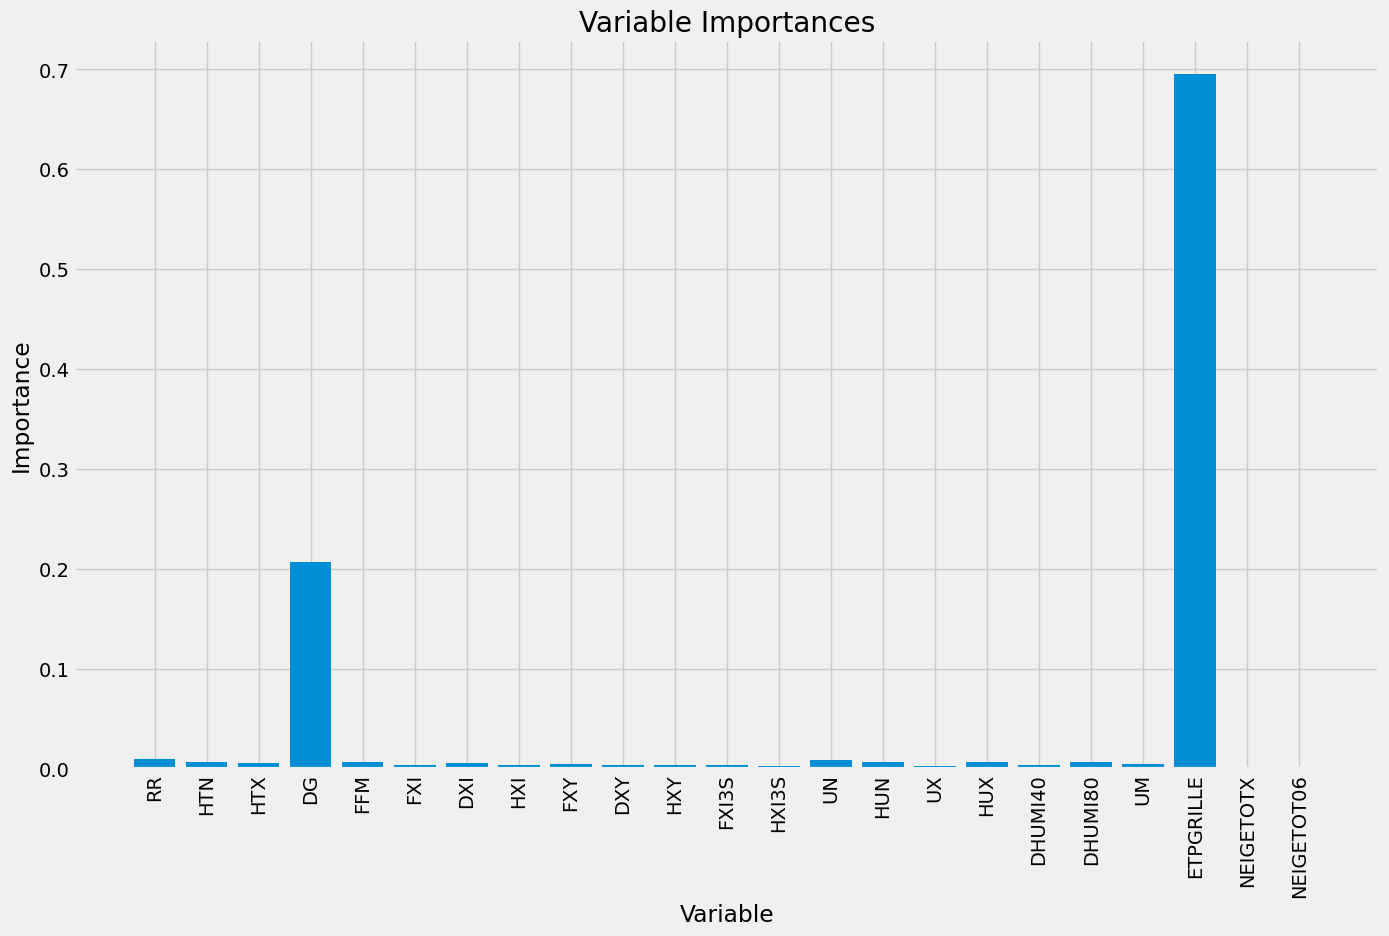

In [20]:
importances = list(rf2.feature_importances_)
feature_list = list(x_train2.columns)

# Set the style
f.plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
f.plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
f.plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
f.plt.ylabel('Importance')
f.plt.xlabel('Variable')
f.plt.title('Variable Importances')

Ainsi les variables les plus importantes sont EPTGRILLE: Evapotranspiration mensuelle, DG. La variable la moins importante est "NEIGTOT06".

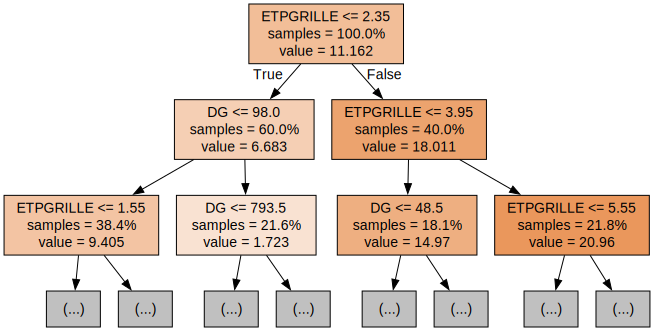

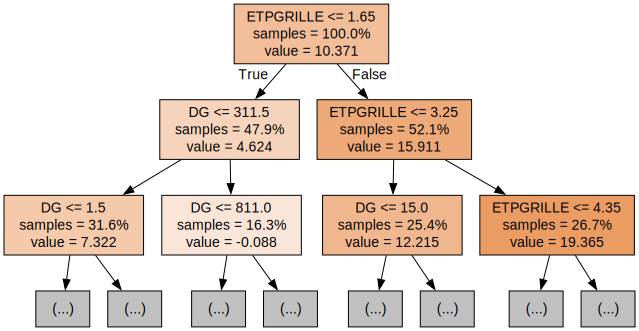

In [21]:
#Visualisation des 2 premiers arbres
for i in range(2):
    tree = rf2.estimators_[i]
    dot_data = f.export_graphviz(tree,
                               feature_names=x_train2.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = f.graphviz.Source(dot_data)
    display(graph)

Le Random Forest génère un grand nombre d'arbres de décision indépendants. Chaque arbre est construit à partir d'un sous-ensemble aléatoire des données d'entraînement, ce qui introduit de la diversité parmi les arbres.

Ici nous avons visualisé les 2 premiers arbres composant notre forêt aléatoire. 


Interprétation du premier arbre:

Nœud racine : L'arbre commence par EPTGRILLE .

Branches : Chaque branche représente une condition sur EPTGRILLE  ( "ETPGRILLE <= 1.65" ou "ETPGRILLE => 1.65").

Feuilles : Chaque feuille donne une prédiction de le température moyenne c'est-à-dire la catégorie ou l'étiquette à laquelle appartient la donnée qui atteint cette feuille suivant si la condition est satisfaite ou non.

Ainsi, l'arbre de décision segmente l'espace des caractéristiques en régions homogènes en termes de températures, facilitant la prédiction de la température.

# Evaluation du modèle

In [ ]:
#On effectue la prédiction du modèle
predict=rf2.predict(x_test2)

In [25]:
print('Mean Absolute Error:',f.mean_absolute_error(TM_test, predict))

mape = f.mean_absolute_percentage_error(TM_test, predict) * 100

# Calcul de R²
r2 = f.r2_score(TM_test, predict)

print(f"MAPE: {mape}%")
print(f"R²: {r2}")

Mean Absolute Error: 2.2478143837990983
MAPE: 18.950044086311575%
R²: 0.6211771336027165


In [26]:
# On ajoute les dates aux prédictions
predict_data= f.pd.DataFrame(data = {'date': TM_test.index, 'prediction': predict})
predict_data.head()

,date,prediction
0,2024-04-10,10.676067
1,2024-04-11,7.180889
2,2024-04-12,14.200019
3,2024-04-13,17.073889
4,2024-04-14,15.765222


Text(0.5, 1.0, 'Actual and Predicted Values')

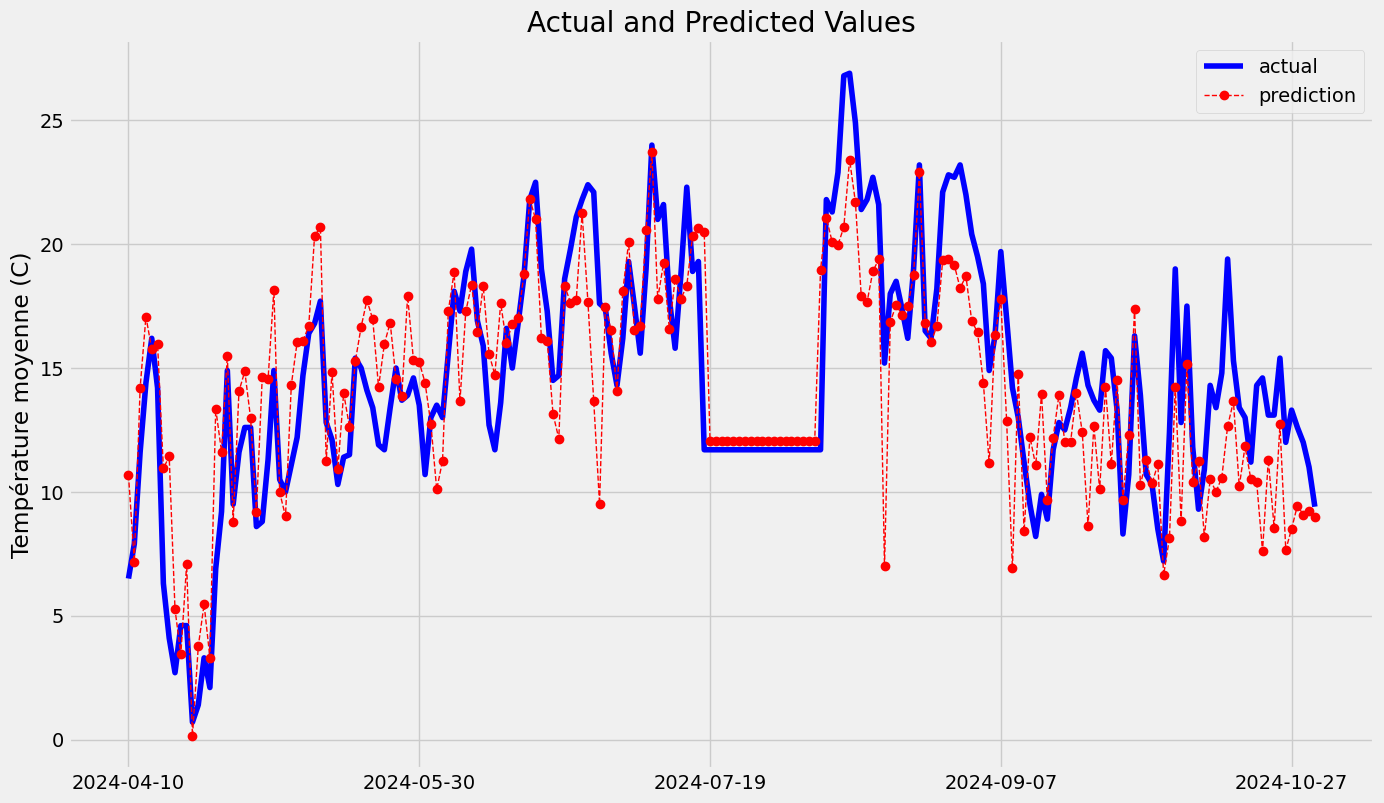

In [27]:

#plot des vraies valeurs
#
f.plt.plot(TM_test.index, TM_test, 'b-', label = 'actual')


# Plot des valeurs prédites
f.plt.plot(predict_data['date'], predict_data['prediction'], 'ro',linestyle="--", linewidth=1, label = 'prediction')

# Limiter le nombre de ticks à 5 maximum
f.plt.gca().xaxis.set_major_locator(f.MaxNLocator(nbins=5))
#plt.xticks(rotation="vertical") 
f.plt.legend()
# Graph labels
f.plt.ylabel('Température moyenne (C)')
f.plt.title('Actual and Predicted Values')